# RF in TopFC analysis
Author: Meisam Ghasemi Bostanabad

## Loading `pandas` DataFrames
Now we load two different `NumPy` arrays. One corresponding to the VV signal and one corresponding to the background.

In [1]:
import uproot
import numpy as np
import pandas as pd
import h5py
import awkward as ak
import seaborn as sns
import matplotlib.pyplot as plt

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

filename = {
    'ttbar':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/ttbar.root',
    'WZ':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/WZ.root',
    'ZZ':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/ZZ.root',
    'signal_charm':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/signal_charm.root'
    }

'''
filename = {
    'ttbar':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/ttbar.root',
    'WZ':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/WZ.root',
    'ZZ':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/ZZ.root',
    'signal_up':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/signal_up.root'}
    }
'''

upfile = {}
params = {}
df = {}

# choose which vars to use (multi dimensional)
#VARS = ['jetNo','jetPTLeading','bjetPT','elecPTLeading','met','testnonTopMass', 'weight'] # choose which vars to use (2d)
VARS = ['jetNo','jetPTLeading', 'jetETA', 'jetPHI','bjetPT', 'bjetETA',
        'elecPTLeading', 'elecETA', 'elecPHI',
        'dielecCOS', 'dielecETA', 'met','testnonTopMass'] # choose which vars to use (2d)

# define trees and branches to make DataFrame
for treename in filename.keys():
    upfile[treename] = uproot.open(filename[treename])
    params[treename] = upfile[treename][treename].arrays(VARS)
    df[treename] = ak.to_dataframe(params[treename])
    # add isSignal variable
    if treename.startswith("signal"): 
        df[treename]['isSignal'] = np.ones(len(df[treename])) 
    else:
        df[treename]['isSignal'] = np.zeros(len(df[treename])) 

## Data exploration

In [2]:
# reduce signal DF size to have resonable Sig/Bkg ratio
df['signal_charm'] = df['signal_charm'][:3500]
df_all = pd.concat([df[treename] for treename in filename.keys()])

In [3]:
print(len(df['signal_charm']))
#print(len(df['signal_charm'][df['isSignal']==1]))

3500


In [4]:
print(set(df['ttbar']['isSignal']))
print(set(df['ttbar']['jetNo']))
#print(set(df['ttbar']['weight']))
#print(set(df['signal_charm']['weight']))

{0.0}
{2, 3, 4, 5, 6}


In [5]:
# number of entries in the backgrounds and signals
tot_bkg = 0
for treename in filename.keys():
    if not 'signal' in treename: tot_bkg += df[treename].shape[0]
    print(treename, ":", df[treename].shape)

print("signal/tot bkg:", round((df['signal_charm'].shape[0]/ tot_bkg),1))
#print("Null entries:", df['signal_charm'].isna().sum())

ttbar : (915, 14)
WZ : (2176, 14)
ZZ : (174, 14)
signal_charm : (3500, 14)
signal/tot bkg: 1.1


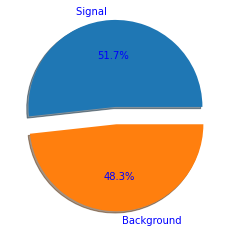

In [6]:
counts_signal = df['signal_charm'].shape[0]
counts_background = tot_bkg
plt.pie([counts_signal, counts_background], explode=[0.1,0.1], shadow=True, labels=['Signal ','Background'], textprops={'color':"b"}, autopct='%1.1f%%');

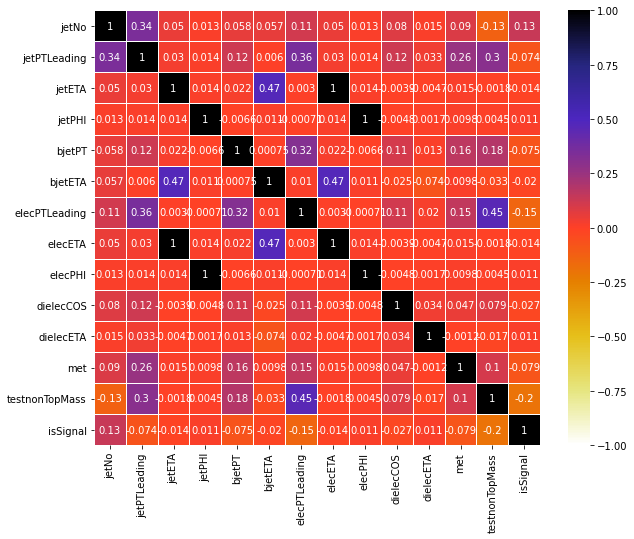

In [7]:
# show the correlation between features
plt.figure(figsize=(10,8))
#sns.heatmap(df_all.corr(), annot=True, linewidth=.5)
sns.heatmap(df_all.corr(), annot=True, linewidth=.5, vmin = -1, vmax = 1,cmap = plt.cm.CMRmap_r);

In [8]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6765 entries, (0, 0) to (1418, 0)
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   jetNo           6765 non-null   int32  
 1   jetPTLeading    6765 non-null   float64
 2   jetETA          6765 non-null   float64
 3   jetPHI          6765 non-null   float64
 4   bjetPT          6765 non-null   float64
 5   bjetETA         6765 non-null   float64
 6   elecPTLeading   6765 non-null   float64
 7   elecETA         6765 non-null   float64
 8   elecPHI         6765 non-null   float64
 9   dielecCOS       6765 non-null   float64
 10  dielecETA       6765 non-null   float64
 11  met             6765 non-null   float64
 12  testnonTopMass  6765 non-null   float64
 13  isSignal        6765 non-null   float64
dtypes: float64(13), int32(1)
memory usage: 776.9 KB


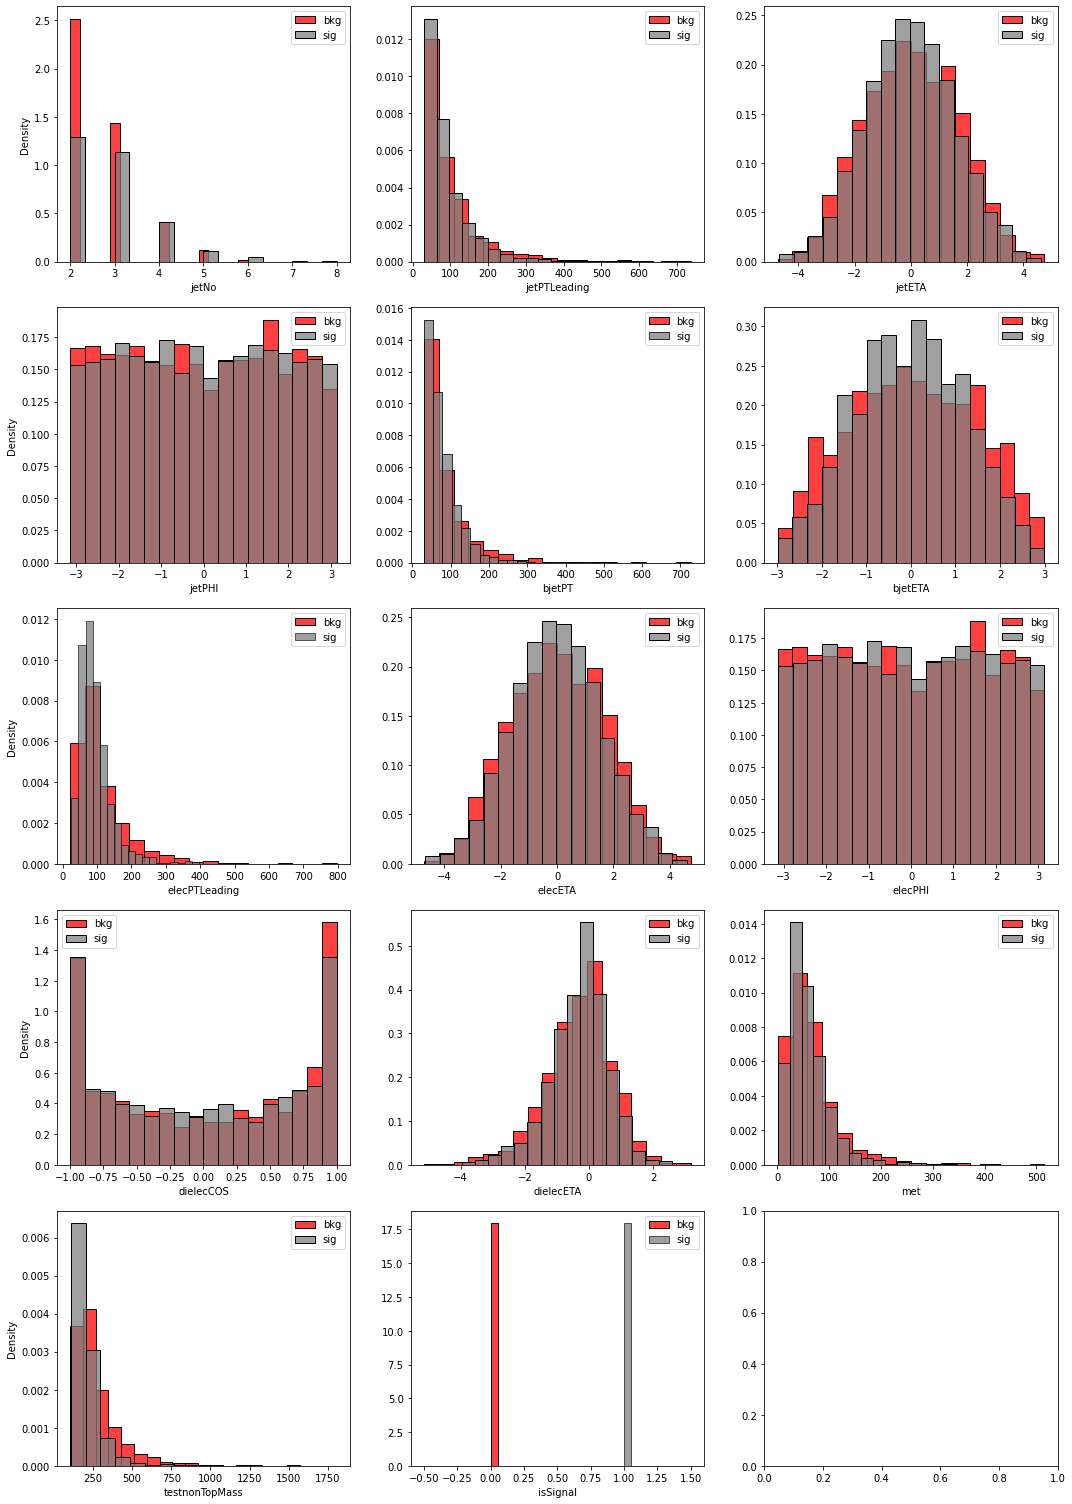

In [9]:
# Function to plot distributions of the float features
import math 
def hist(df1, df2, cols, bins, ncols = 3):
    nrows = math.ceil(len(cols) / ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize = (5 * ncols, 4.2 * nrows), sharey = False)
    for i in range(len(cols)):
        #sns.histplot(data = df, x = cols[i], bins = bins, hue = 'isSignal', palette = ['grey', 'red'], ax = ax[i // ncols, i % ncols], stat="probability")
        sns.histplot(data = df1, x = cols[i], bins = bins, color = 'red',
                      ax = ax[i // ncols, i % ncols], stat="density", label='bkg')
        sns.histplot(data = df2, x = cols[i], bins = bins, color = 'grey',
                      ax = ax[i // ncols, i % ncols], stat="density", label='sig')       
        ax[i // ncols, i % ncols].set_xlabel(cols[i])
        ax[i // ncols, i % ncols].legend()
        if i % ncols != 0:
            ax[i // ncols, i % ncols].set_ylabel(" ")
        
    plt.tight_layout()
    plt.show()

# Distributions of the float features
hist(df_all[df_all['isSignal']==0].replace(-999, np.nan),
     df_all[df_all['isSignal']==1].replace(-999, np.nan),
     #list(df_all.columns[df_all.dtypes == 'float64']),
     list(df_all.columns),
     bins = math.floor(len(df_all)**(1/3)),
     ncols = 3)

In [10]:
# function to make ML output and significant plot
samples =['ttbar', 'WZ', 'ZZ', 'signal_charm']

def plot_SoverB(data, SoverB_hist_dict):
    
    signal = r'signal_charm' # which sample is the signal

    # *******************
    # general definitions (shouldn't need to change)

    for x_variable,hist in SoverB_hist_dict.items(): # access the dictionary of histograms defined in the cell above

        h_bin_width = hist['bin_width'] # get the bin width defined in the cell above
        h_num_bins = hist['num_bins'] # get the number of bins defined in the cell above
        h_xrange_min = hist['xrange_min'] # get the x-range minimum defined in the cell above
        h_xlabel = hist['xlabel'] # get the x-axis label defined in the cell above
    
        bin_edges = [ h_xrange_min + x*h_bin_width for x in range(h_num_bins+1) ] # bin limits
        bin_centres = [ h_xrange_min+h_bin_width/2 + x*h_bin_width for x in range(h_num_bins) ] # bin centres
        
        signal_x = data[signal][x_variable] # histogram the signal
    
        mc_x = [] # define list to hold the Monte Carlo histogram entries

        for s in samples: # loop over samples
            if s not in ['data', signal]: # if not data nor signal
                mc_x = [*mc_x, *data[s][x_variable] ] # append to the list of Monte Carlo histogram entries
                #test=[]; test.append(df[s]['RF_output_prob'].values)


    
    
        # *************
        # Signal and background distributions
        # *************
        distributions_axes = plt.gca() # get current axes
 
        mc_heights = distributions_axes.hist(mc_x, bins=bin_edges, color='red', 
                                             label='Total background',
                                             histtype='step', # lineplot that's unfilled
                                             density=True ) # normalize to form probability density
        signal_heights = distributions_axes.hist(signal_x, bins=bin_edges, color='blue',
                                                 label=signal, 
                                                 histtype='step', # lineplot that's unfilled
                                                 density=True, # normalize to form probability density: area under the histogram integrates to 1
                                                 linestyle='--' ) # dashed line
        
        distributions_axes.set_xlim( left=bin_edges[0], right=bin_edges[-1] ) # x-limits of the distributions axes
        distributions_axes.set_ylabel('Arbitrary units' ) # y-axis label for distributions axes
        y_max = max(max(signal_heights[0]), max(mc_heights[0]) )
        #distributions_axes.set_ylim( top=max(signal_heights[0])*1.3 ) # set y-axis limits
        distributions_axes.set_ylim( top=y_max*1.2 ) # set y-axis limits
        #distributions_axes.set_ylim( top=max(signal_heights[0])*1.3 ) # set y-axis limits
        plt.title('Signal and background '+x_variable+' distributions') # add title
        distributions_axes.legend() # draw the legend
        distributions_axes.set_xlabel( h_xlabel ) # x-axis label
            
        plt.show() # show the Signal and background distributions
    
    
        # *************
        # Signal to background ratio
        # *************
        plt.figure() # start new figure
        SoverB = [] # list to hold S/B values
        for cut_value in bin_edges: # loop over bins
            #signal_weights_passing_cut = sum(data[signal][data[signal][x_variable]>cut_value].totalWeight)
            signal_weights_passing_cut = len(data[signal][data[signal][x_variable]>cut_value])
            background_weights_passing_cut = 0 # start counter for background weights passing cut
            for s in samples: # loop over samples
                if s not in ['data', signal]: # if not data nor signal
                    #background_weights_passing_cut += sum(data[s][data[s][x_variable]>cut_value].totalWeight)
                    background_weights_passing_cut += len(data[s][data[s][x_variable]>cut_value])
            if background_weights_passing_cut!=0: # some background passes cut
                SoverB_value = signal_weights_passing_cut/background_weights_passing_cut
                SoverB_percent = 100*SoverB_value # multiply by 100 for percentage
                SoverB.append(SoverB_percent) # append to list of S/B values
        
        SoverB_axes = plt.gca() # get current axes
        SoverB_axes.plot( bin_edges[:len(SoverB)], SoverB ) # plot the data points
        SoverB_axes.set_xlim( left=bin_edges[0], right=bin_edges[-1] ) # set the x-limit of the main axes
        #SoverB_axes.set_ylim( 100, 1000)
        SoverB_axes.set_ylabel( 'S/B (%)' ) # write y-axis label for main axes
        plt.title('Signal to background ratio for different '+x_variable+' cut values', family='sans-serif')
        SoverB_axes.set_xlabel( h_xlabel ) # x-axis label 
        
        plt.show() # show S/B plot
    
    return

## Define the models

## Random Forest
Random forest is a commonly-used machine learning algorithm trademarked by Leo Breiman and Adele Cutler, which combines the output of multiple decision trees to reach a single result. Its ease of use and flexibility have fueled its adoption, as it handles both classification and regression problems.

## Dividing the data into testing and training dataset

We will split the data into two parts (one for training+validation and one for testing). 
We will also apply "standard scaling" preprocessing: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html i.e. making the mean = 0 and the RMS = 1 for all input variables (based **only** on the training/validation dataset).
We will also define our early stopping criteria to prevent over-fitting and we will save the model based on the best `val_loss`.

In [11]:
NDIM = len(VARS)
dataset = df_all.values
X = dataset[:,0:NDIM]
Y = dataset[:,NDIM]

from sklearn.model_selection import train_test_split
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

# preprocessing: standard scalar
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train_val)
X_train_val = scaler.transform(X_train_val)
X_test = scaler.transform(X_test)

# Random Forest classifier for prediction and evaluate the model

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score, confusion_matrix

# Train classifier
import time
start = time.time() # time at start of whole processing

# the parameters for initializing are called hyperprameters
#RF_clf = RandomForestClassifier(criterion='gini', max_depth=8, n_estimators=1000, random_state=420) # initialise your random forest classifier
RF_clf = RandomForestClassifier(random_state=420) # initialise your random forest classifier
RF_clf.fit(X_train_val, Y_train_val) # fit to the training data
elapsed = time.time() - start # time after whole processing
print("Time taken: "+str(round(elapsed,1))+"s") # print total time taken to process every file

y_pred_RF = RF_clf.predict(X_test) # make predictions on the test data

# for my own curiosity
y_pred_RF_train = RF_clf.predict(X_train_val)
y_pred_RF_tot = RF_clf.predict(scaler.transform(X))


# See how well the classifier does, Acc = correct data / tot data
# The accuracy score is defined as the ratio of correctly identified data points to all data points.
print("Test accuracy:", accuracy_score(Y_test, y_pred_RF))
print("Train accuracy", accuracy_score(Y_train_val, y_pred_RF_train))
print("Total accuracy", accuracy_score(Y, y_pred_RF_tot))

print("Classification report for the test set")
print(classification_report(Y_test.round(), y_pred_RF.round(), target_names=['background', 'signal']))
#print("Classification report for the train set")
#print(classification_report(Y_train_val.round(), y_pred_RF_train.round(), target_names=['background', 'signal']))
print("Classification report for the total set")
print(classification_report(Y.round(), y_pred_RF_tot.round(), target_names=['background', 'signal']))

fpr_rf, tpr_rf, thresholds_rf = roc_curve(Y_test, y_pred_RF)

df_all['dense_RF'] = RF_clf.predict(scaler.transform(X)).round() # add prediction to array

Time taken: 1.3s
Test accuracy: 0.9194382852919438
Train accuracy 1.0
Total accuracy 0.9838876570583888
Classification report for the test set
              precision    recall  f1-score   support

  background       0.92      0.91      0.92       666
      signal       0.92      0.92      0.92       687

    accuracy                           0.92      1353
   macro avg       0.92      0.92      0.92      1353
weighted avg       0.92      0.92      0.92      1353

Classification report for the total set
              precision    recall  f1-score   support

  background       0.98      0.98      0.98      3265
      signal       0.98      0.99      0.98      3500

    accuracy                           0.98      6765
   macro avg       0.98      0.98      0.98      6765
weighted avg       0.98      0.98      0.98      6765



In [12]:
from pprint import pprint
print('Parameters currently in use:\n')
pprint(RF_clf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 420,
 'verbose': 0,
 'warm_start': False}


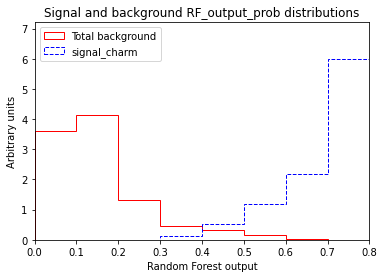

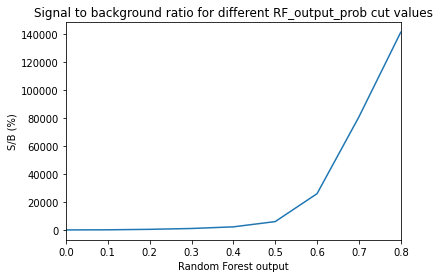

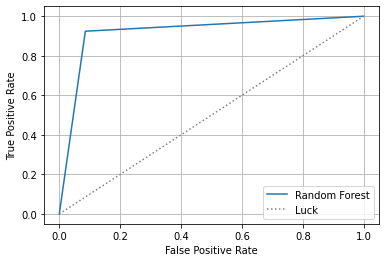

In [13]:
#plt.style.use('default')

# add RF probability
y_tot_prob_RF = RF_clf.predict_proba(scaler.transform(X))[:,1]
y_tot_RF = RF_clf.predict(scaler.transform(X))
cumulative_events = 0 # start counter for total number of events for which output is saved
for key in filename.keys(): # loop over samples
    df[key]['RF_output_prob'] = y_tot_prob_RF[cumulative_events:cumulative_events+len(df[key])]
    df[key]['RF_output'] = y_tot_RF[cumulative_events:cumulative_events+len(df[key])]
    cumulative_events += len(df[key]) # increment counter for total number of events
    #print(df[key]['RF_output']) # print the dataframe column NN_output

# probability and significance plots
RF_output_prob = { # dictionary containing plotting parameters for the mllll histogram
    # change plotting parameters
    'bin_width':0.1, # width of each histogram bin
    'num_bins':8, # number of histogram bins
    'xrange_min':0, # minimum on x-axis
    'xlabel':'Random Forest output', # x-axis label
}

SoverB_hist_dict = {'RF_output_prob':RF_output_prob}
plot_SoverB(df, SoverB_hist_dict)    

# plot ROC curve
plt.plot(fpr_rf, tpr_rf, label='Random Forest') # plot random forest ROC
plt.plot([0, 1], [0, 1], linestyle='dotted', color='grey', label='Luck') # plot diagonal line to indicate luck
plt.xlabel('False Positive Rate') # x-axis label
plt.ylabel('True Positive Rate') # y-axis label
plt.grid() # add a grid to the plot
plt.legend() # add a legend

In [14]:
# Get numerical feature importances
feature_list = VARS
feature_list[-1] = 'NonSM Top mass'

importances = list(RF_clf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: NonSM Top mass       Importance: 0.14
Variable: bjetPT               Importance: 0.1
Variable: elecPTLeading        Importance: 0.1
Variable: met                  Importance: 0.1
Variable: jetPTLeading         Importance: 0.09
Variable: bjetETA              Importance: 0.09
Variable: dielecCOS            Importance: 0.09
Variable: dielecETA            Importance: 0.09
Variable: jetETA               Importance: 0.05
Variable: elecETA              Importance: 0.05
Variable: jetPHI               Importance: 0.04
Variable: elecPHI              Importance: 0.04
Variable: jetNo                Importance: 0.03


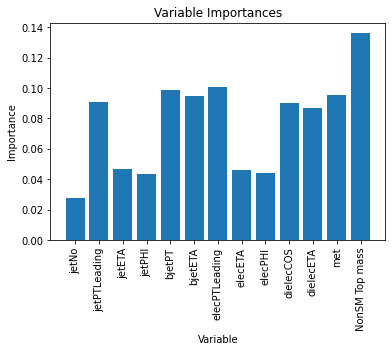

In [15]:
# Set the style
#plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances'); 

## First RF Hyperparameter optimization

In [20]:
from pprint import pprint

rf = RandomForestClassifier(random_state = 42)
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [32]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 100, scoring='accuracy', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(X_train_val, Y_train_val);

In [34]:
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': False}

In [37]:
best_random = rf_random.best_estimator_
pprint(best_random.get_params())

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 50,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 800,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


## Second RF optimization considering overfitting

In [ ]:
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 420,
 'verbose': 0,
 'warm_start': False}

In [17]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 10, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True]

# Create the random grid
random_grid_fit = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap               
               }

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random_fit = RandomizedSearchCV(estimator=rf, param_distributions=random_grid_fit,
                              n_iter = 100, scoring='accuracy', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random_fit.fit(X_train_val, Y_train_val);
rf_random_fit.best_params_
best_random_fit = rf_random_fit.best_estimator_
pprint(best_random_fit.get_params())

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 110,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [21]:
# w/o overfit
y_pred_RF_opt_fit = best_random_fit.predict(X_test).round() # make predictions on the test data
y_pred_RF_train_opt_fit = best_random_fit.predict(X_train_val).round()
y_pred_RF_tot_opt_fit = best_random_fit.predict(scaler.transform(X)).round()

# See how well the classifier does, Acc = correct data / tot data
# The accuracy score is defined as the ratio of correctly identified data points to all data points.
print("Test accuracy:", accuracy_score(Y_test, y_pred_RF_opt_fit))
print("Train accuracy", accuracy_score(Y_train_val, y_pred_RF_train_opt_fit))
print("Total accuracy", accuracy_score(Y, y_pred_RF_tot_opt_fit))

print("Classification report for the test set")
print(classification_report(Y_test.round(), y_pred_RF_opt_fit.round(), target_names=['background', 'signal']))
#print("Classification report for the train set")
#print(classification_report(Y_train_val.round(), y_pred_RF_train.round(), target_names=['background', 'signal']))
#print("Classification report for the total set")
#print(classification_report(Y.round(), y_pred_RF_tot_opt_fit.round(), target_names=['background', 'signal']))

fpr_rf_opt_fit, tpr_rf_opt_fit, thresholds_rf_opt_fit = roc_curve(Y_test, y_pred_RF_opt_fit)

df_all['dense_RF_opt_overfit'] = best_random_fit.predict(scaler.transform(X)).round() # add prediction to array

Test accuracy: 0.9283074648928308
Train accuracy 1.0
Total accuracy 0.9856614929785662
Classification report for the test set
              precision    recall  f1-score   support

  background       0.93      0.93      0.93       666
      signal       0.93      0.93      0.93       687

    accuracy                           0.93      1353
   macro avg       0.93      0.93      0.93      1353
weighted avg       0.93      0.93      0.93      1353



In [161]:
# with overfit
y_pred_RF_opt = best_random.predict(X_test).round() # make predictions on the test data
y_pred_RF_train_opt = best_random.predict(X_train_val).round()
y_pred_RF_tot_opt = best_random.predict(scaler.transform(X)).round()

# See how well the classifier does, Acc = correct data / tot data
# The accuracy score is defined as the ratio of correctly identified data points to all data points.
print("Test accuracy:", accuracy_score(Y_test, y_pred_RF_opt))
print("Train accuracy", accuracy_score(Y_train_val, y_pred_RF_train_opt))
print("Total accuracy", accuracy_score(Y, y_pred_RF_tot_opt))

print("Classification report for the test set")
print(classification_report(Y_test.round(), y_pred_RF_opt.round(), target_names=['background', 'signal']))
#print("Classification report for the train set")
#print(classification_report(Y_train_val.round(), y_pred_RF_train.round(), target_names=['background', 'signal']))
#print("Classification report for the total set")
#print(classification_report(Y.round(), y_pred_RF_tot_opt.round(), target_names=['background', 'signal']))

fpr_rf_opt, tpr_rf_opt, thresholds_rf_opt = roc_curve(Y_test, y_pred_RF_opt)

df_all['dense_RF_opt'] = best_random.predict(scaler.transform(X)).round() # add prediction to array

print("\n---------------------------------------\n")

# w/o overfit
y_pred_RF_opt_fit = best_random_fit.predict(X_test).round() # make predictions on the test data
y_pred_RF_train_opt_fit = best_random_fit.predict(X_train_val).round()
y_pred_RF_tot_opt_fit = best_random_fit.predict(scaler.transform(X)).round()

# See how well the classifier does, Acc = correct data / tot data
# The accuracy score is defined as the ratio of correctly identified data points to all data points.
print("Test accuracy:", accuracy_score(Y_test, y_pred_RF_opt_fit))
print("Train accuracy", accuracy_score(Y_train_val, y_pred_RF_train_opt_fit))
print("Total accuracy", accuracy_score(Y, y_pred_RF_tot_opt_fit))

print("Classification report for the test set")
print(classification_report(Y_test.round(), y_pred_RF_opt_fit.round(), target_names=['background', 'signal']))
#print("Classification report for the train set")
#print(classification_report(Y_train_val.round(), y_pred_RF_train.round(), target_names=['background', 'signal']))
#print("Classification report for the total set")
#print(classification_report(Y.round(), y_pred_RF_tot_opt_fit.round(), target_names=['background', 'signal']))

fpr_rf_opt_fit, tpr_rf_opt_fit, thresholds_rf_opt_fit = roc_curve(Y_test, y_pred_RF_opt_fit)

df_all['dense_RF_opt_overfit'] = best_random_fit.predict(scaler.transform(X)).round() # add prediction to array


Test accuracy: 0.9386548410938654
Train accuracy 0.999630450849963
Total accuracy 0.6976345140335826
Classification report for the test set
              precision    recall  f1-score   support

  background       0.94      0.93      0.94       666
      signal       0.94      0.94      0.94       687

    accuracy                           0.94      1353
   macro avg       0.94      0.94      0.94      1353
weighted avg       0.94      0.94      0.94      1353


---------------------------------------

Test accuracy: 0.861049519586105
Train accuracy 0.9488174427198818
Total accuracy 0.7229848429137558
Classification report for the test set
              precision    recall  f1-score   support

  background       0.91      0.80      0.85       666
      signal       0.83      0.92      0.87       687

    accuracy                           0.86      1353
   macro avg       0.87      0.86      0.86      1353
weighted avg       0.87      0.86      0.86      1353



In [66]:
df_all[df_all['isSignal']==1].head(10)
print(len(df_all[(df_all['isSignal'] == 0) & (df_all['dense_RF_opt']==1)]))

0


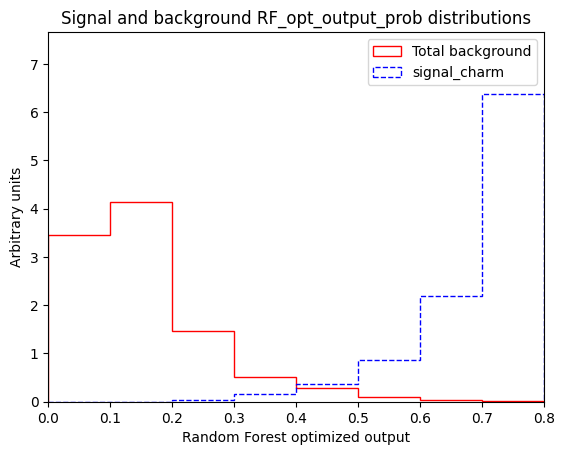

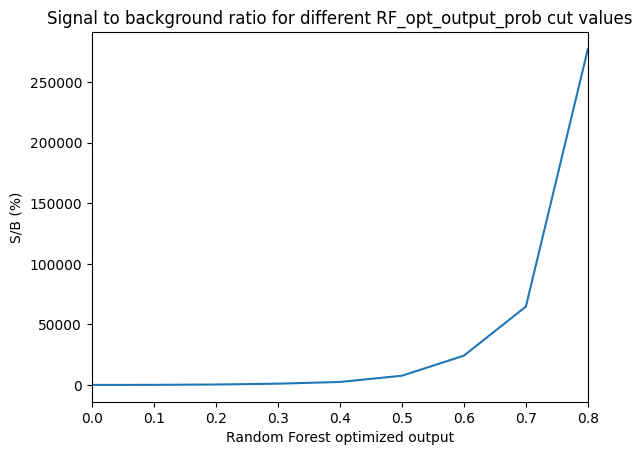

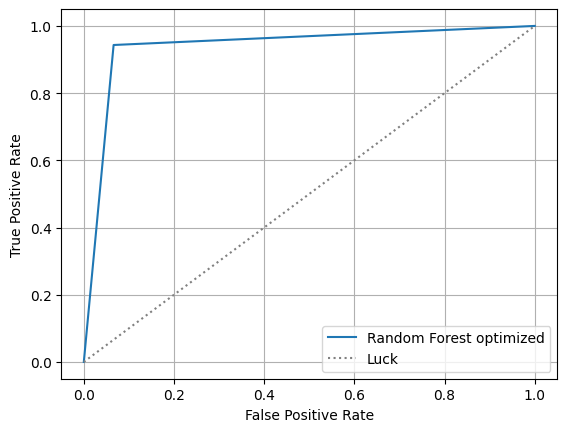

In [54]:
# add RF probability
y_tot_prob_RF_opt = best_random.predict(scaler.transform(X))
y_tot_RF_opt = best_random.predict(scaler.transform(X)).round()
cumulative_events = 0 # start counter for total number of events for which output is saved
for key in filename.keys(): # loop over samples
    df[key]['RF_opt_output_prob'] = y_tot_prob_RF_opt[cumulative_events:cumulative_events+len(df[key])]
    df[key]['RF_opt_output'] = y_tot_RF_opt[cumulative_events:cumulative_events+len(df[key])]
    cumulative_events += len(df[key]) # increment counter for total number of events
    #print(df[key]['RF_output']) # print the dataframe column NN_output

# probability and significance plots
RF_opt_output_prob = { # dictionary containing plotting parameters for the mllll histogram
    # change plotting parameters
    'bin_width':0.1, # width of each histogram bin
    'num_bins':8, # number of histogram bins
    'xrange_min':0, # minimum on x-axis
    'xlabel':'Random Forest optimized output', # x-axis label
}

SoverB_hist_dict = {'RF_opt_output_prob':RF_opt_output_prob}
plot_SoverB(df, SoverB_hist_dict)    

# plot ROC curve
plt.plot(fpr_rf_opt, tpr_rf_opt, label='Random Forest optimized') # plot random forest ROC
plt.plot([0, 1], [0, 1], linestyle='dotted', color='grey', label='Luck') # plot diagonal line to indicate luck
plt.xlabel('False Positive Rate') # x-axis label
plt.ylabel('True Positive Rate') # y-axis label
plt.grid() # add a grid to the plot
plt.legend() # add a legend

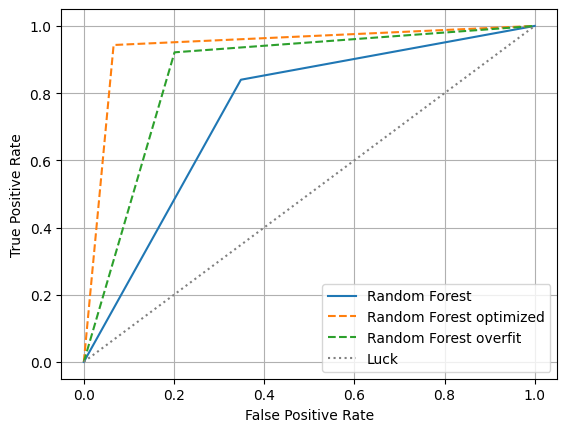

In [162]:
# plot ROC curve
plt.plot(fpr_rf, tpr_rf, label='Random Forest') # plot random forest ROC
plt.plot(fpr_rf_opt, tpr_rf_opt, linestyle='dashed', label='Random Forest optimized') # plot random forest-opt ROC
plt.plot(fpr_rf_opt_fit, tpr_rf_opt_fit, linestyle='dashed', label='Random Forest overfit') # plot random forest-opt with overfit ROC
plt.plot([0, 1], [0, 1], linestyle='dotted', color='grey', label='Luck') # plot diagonal line to indicate luck
plt.xlabel('False Positive Rate') # x-axis label
plt.ylabel('True Positive Rate') # y-axis label
plt.grid() # add a grid to the plot
plt.legend() # add a legend

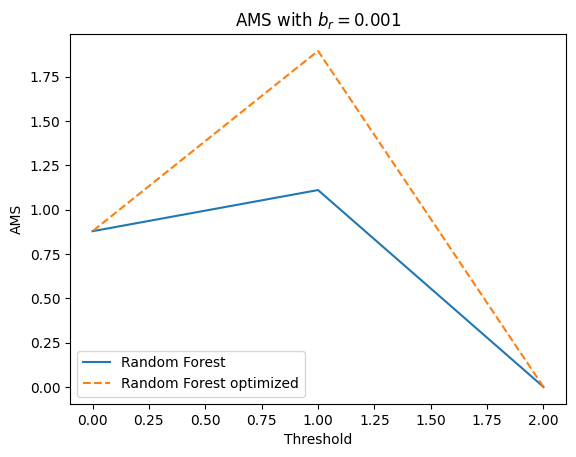

In [118]:
# plot AMS
def AMS(tpr, fpr, b_reg): # define function to calculate AMS
    return np.sqrt(2*((tpr+fpr+b_reg)*np.log(1+tpr/(fpr+b_reg))-tpr)) # equation for AMS

ams_rf = AMS(tpr_rf, fpr_rf, 0.001) # get AMS for random forest classifier
ams_rf_opt = AMS(tpr_rf_opt, fpr_rf_opt, 0.001) # get AMS for random forest-opt classifier

plt.plot(thresholds_rf, ams_rf, label="Random Forest")  # plot Random forest AMS
plt.plot(thresholds_rf_opt, ams_rf_opt, linestyle='dashed', label="Random Forest optimized")  # plot Random forest-opt AMS
plt.xlabel("Threshold")  # x-axis label
plt.ylabel("AMS")  # y-axis label
plt.title("AMS with $b_r=0.001$")  # add plot title
plt.legend()  # add legend

In [57]:
# Get numerical feature importances
feature_list = VARS
feature_list[-1] = 'NonSM Top mass'

importances = list(best_random.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: NonSM Top mass       Importance: 0.16
Variable: bjetPT               Importance: 0.11
Variable: elecPTLeading        Importance: 0.11
Variable: jetPTLeading         Importance: 0.1
Variable: bjetETA              Importance: 0.1
Variable: dielecCOS            Importance: 0.1
Variable: dielecETA            Importance: 0.1
Variable: met                  Importance: 0.1
Variable: jetNo                Importance: 0.03
Variable: jetETA               Importance: 0.03
Variable: elecETA              Importance: 0.03
Variable: jetPHI               Importance: 0.02
Variable: elecPHI              Importance: 0.02


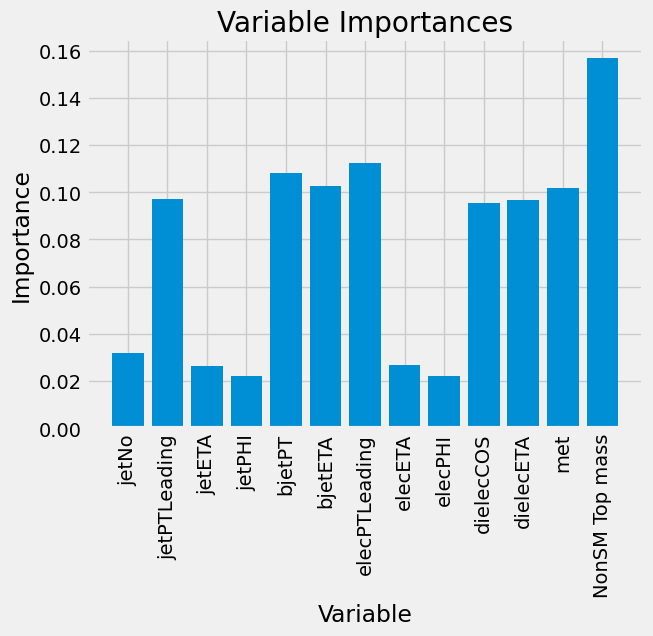

In [58]:
# Set the style
plt.style.use('fivethirtyeight')
#plt.style.use('default')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances'); 

In [68]:
from joblib import dump, load
dump(best_random, 'best_random_RF.joblib')

['best_random_RF.joblib']

## Extend RF-opt to the whole dataset 

In [97]:
filename = {
    'ttbar':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/ttbar.root',
    'WZ':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/WZ.root',
    'ZZ':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/ZZ.root',
    'signal_charm':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/signal_charm.root'
    }

'''
filename = {
    'ttbar':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/ttbar.root',
    'WZ':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/WZ.root',
    'ZZ':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/ZZ.root',
    'signal_up':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/signal_up.root'}
    }
'''
VARS = ['jetNo','jetPTLeading', 'jetETA', 'jetPHI','bjetPT', 'bjetETA',
        'elecPTLeading', 'elecETA', 'elecPHI',
        'dielecCOS', 'dielecETA', 'met','testnonTopMass'] # choose which vars to use (2d)

upfile = {}
params = {}
df = {}

# define trees and branches to make DataFrame
for treename in filename.keys():
    upfile[treename] = uproot.open(filename[treename])
    params[treename] = upfile[treename][treename].arrays(VARS)
    df[treename] = ak.to_dataframe(params[treename])
    # add isSignal variable
    if treename.startswith("signal"): 
        df[treename]['isSignal'] = np.ones(len(df[treename])) 
    else:
        df[treename]['isSignal'] = np.zeros(len(df[treename])) 

NDIM = len(VARS)
df_all = pd.concat([df[treename] for treename in filename.keys()])
dataset = df_all.values
X = dataset[:,0:NDIM]
Y = dataset[:,NDIM]

#X_train_val = scaler.transform(X_train_val)
#X_test = scaler.transform(X_test)

In [107]:
y_pred_RF_opt = best_random.predict(X_test).round() # make predictions on the test data
y_pred_RF_train_opt = best_random.predict(X_train_val).round()
y_pred_RF_tot_opt = best_random.predict(scaler.transform(X)).round()

# See how well the classifier does, Acc = correct data / tot data
# The accuracy score is defined as the ratio of correctly identified data points to all data points.
#print("Test accuracy:", accuracy_score(Y_test, y_pred_RF_opt))
#print("Train accuracy", accuracy_score(Y_train_val, y_pred_RF_train_opt))
print("Total accuracy", accuracy_score(Y, y_pred_RF_tot_opt))

#print("Classification report for the test set")
#print(classification_report(Y_test.round(), y_pred_RF_opt.round(), target_names=['background', 'signal']))
#print("Classification report for the train set")
#print(classification_report(Y_train_val.round(), y_pred_RF_train.round(), target_names=['background', 'signal']))
print("Classification report for the total set")
print(classification_report(Y.round(), y_pred_RF_tot_opt.round(), target_names=['background', 'signal']))

print("Confusion matrix:\n", confusion_matrix(Y.round(), y_pred_RF_tot_opt.round()))

fpr_rf_opt_tot, tpr_rf_opt_tot, thresholds_rf_opt_tot = roc_curve(Y, y_pred_RF_tot_opt)

df_all['dense_RF_opt'] = best_random.predict(scaler.transform(X)).round() # add prediction to array

Total accuracy 0.6976345140335826
Classification report for the total set
              precision    recall  f1-score   support

  background       0.10      0.99      0.18      3265
      signal       1.00      0.69      0.81     94643

    accuracy                           0.70     97908
   macro avg       0.55      0.84      0.50     97908
weighted avg       0.97      0.70      0.79     97908

Confusion matrix:
 [[ 3220    45]
 [29559 65084]]


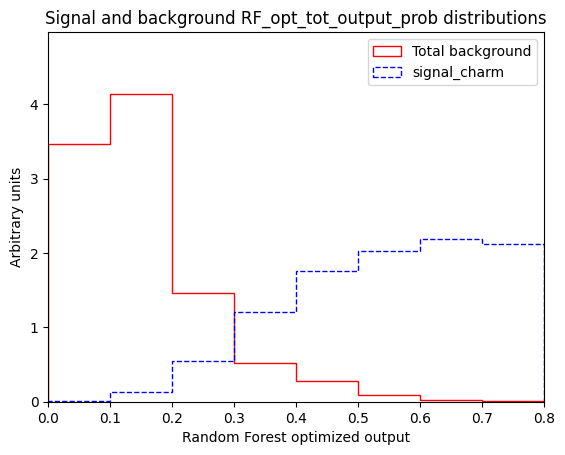

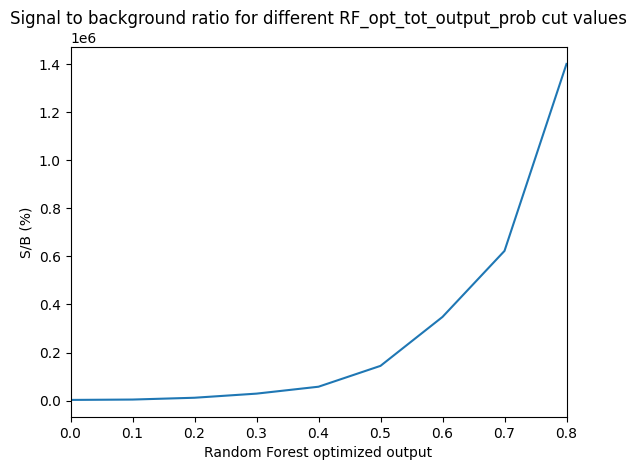

In [106]:
y_TOT_prob_RF_opt = best_random.predict(scaler.transform(X))
y_TOT_RF_opt = best_random.predict(scaler.transform(X)).round()
cumulative_events = 0 # start counter for total number of events for which output is saved
for key in filename.keys(): # loop over samples
    df[key]['RF_opt_tot_output_prob'] = y_TOT_prob_RF_opt[cumulative_events:cumulative_events+len(df[key])]
    df[key]['RF_opt_tot_output'] = y_TOT_RF_opt[cumulative_events:cumulative_events+len(df[key])]
    cumulative_events += len(df[key]) # increment counter for total number of events
    #print(df[key]['RF_output']) # print the dataframe column NN_output

# probability and significance plots
RF_opt_tot_output_prob = { # dictionary containing plotting parameters for the mllll histogram
    # change plotting parameters
    'bin_width':0.1, # width of each histogram bin
    'num_bins':8, # number of histogram bins
    'xrange_min':0, # minimum on x-axis
    'xlabel':'Random Forest optimized output', # x-axis label
}

SoverB_hist_dict = {'RF_opt_tot_output_prob':RF_opt_tot_output_prob}
plot_SoverB(df, SoverB_hist_dict)   

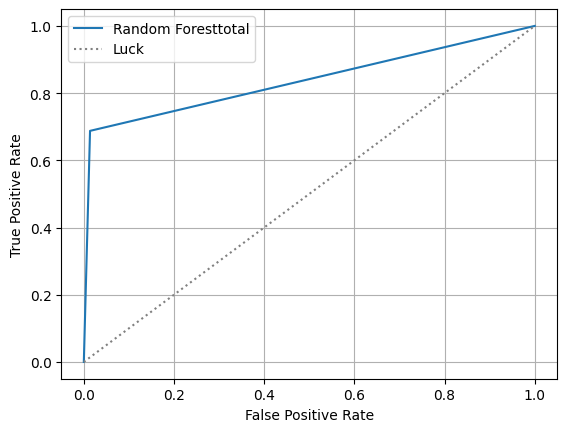

In [101]:
# plot ROC curve
plt.style.use('default')
plt.plot(fpr_rf_opt_tot, tpr_rf_opt_tot, label='Random Foresttotal') # plot random forest ROC
plt.plot([0, 1], [0, 1], linestyle='dotted', color='grey', label='Luck') # plot diagonal line to indicate luck
plt.xlabel('False Positive Rate') # x-axis label
plt.ylabel('True Positive Rate') # y-axis label
plt.grid() # add a grid to the plot
plt.legend() # add a legend

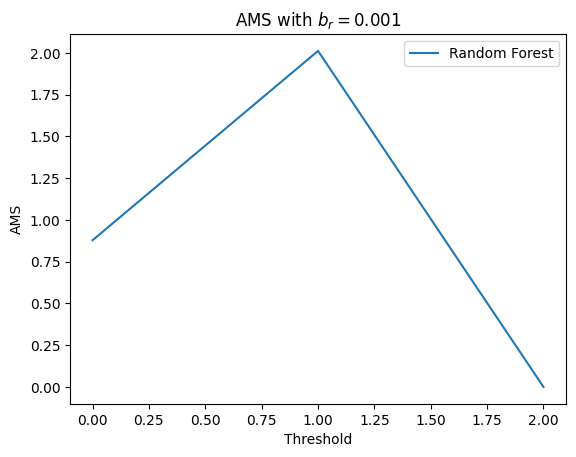

In [117]:
ams_rf_opt_tot = AMS(tpr_rf_opt_tot, fpr_rf_opt_tot, 0.001) # get AMS for random forest classifier

plt.plot(thresholds_rf_opt_tot, ams_rf_opt_tot, label="Random Forest")  # plot Random forest AMS
plt.xlabel("Threshold")  # x-axis label
plt.ylabel("AMS")  # y-axis label
plt.title("AMS with $b_r=0.001$")  # add plot title
plt.legend()  # add legend

## Overfit checking

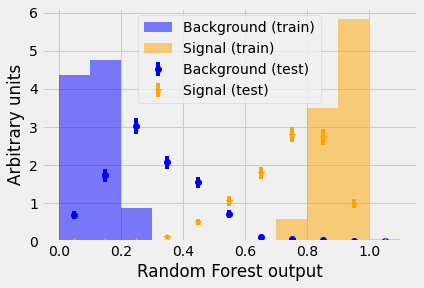

In [21]:
def compare_train_test(clf, X_train, y_train, X_test, y_test, xlabel):
    decisions = [] # list to hold decisions of classifier
    for X,y in ((X_train, y_train), (X_test, y_test)): # train and test
        d1 = clf.predict_proba(X[y<0.5])[:, 1] # background
        d2 = clf.predict_proba(X[y>0.5])[:, 1] # signal
        decisions += [d1, d2] # add to list of classifier decision

    highest_decision = max(np.max(d) for d in decisions) # get maximum score
    bin_edges = [] # list to hold bin edges
    bin_edge = -0.1 # start counter for bin_edges
    while bin_edge < highest_decision: # up to highest score
        bin_edge += 0.1 # increment
        bin_edges.append(bin_edge)

    # Training plots
    plt.hist(decisions[0], # background in train set
            bins=bin_edges, # lower and upper range of the bins
            density=True, # area under the histogram will sum to 1
            histtype='stepfilled', # lineplot that's filled
            color='blue', label='Background (train)', # Background (train)
            alpha=0.5 ) # half transparency
    plt.hist(decisions[1], # signal in train set
            bins=bin_edges, # lower and upper range of the bins
            density=True, # area under the histogram will sum to 1
            histtype='stepfilled', # lineplot that's filled
            color='orange', label='Signal (train)', # Signal (train)
            alpha=0.5 ) # half transparency

    # Testing plots
    hist_background, bin_edges = np.histogram(decisions[2], # background test
                                            bins=bin_edges, # number of bins in function definition
                                            density=True ) # area under the histogram will sum to 1

    scale = len(decisions[2]) / sum(hist_background) # between raw and normalised
    err_background = np.sqrt(hist_background * scale) / scale # error on test background

    width = 0.1 # histogram bin width
    center = (bin_edges[:-1] + bin_edges[1:]) / 2 # bin centres

    plt.errorbar(x=center, y=hist_background, yerr=err_background, fmt='o', # circles
                c='blue', label='Background (test)' ) # Background (test)

    hist_signal, bin_edges = np.histogram(decisions[3], # siganl test
                                        bins=bin_edges, # number of bins in function definition
                                        density=True ) # area under the histogram will sum to 1

    scale = len(decisions[3]) / sum(hist_signal) # between raw and normalised
    err_signal = np.sqrt(hist_signal * scale) / scale # error on test background

    plt.errorbar(x=center, y=hist_signal, yerr=err_signal, fmt='*', # circles
                c='orange', label='Signal (test)' ) # Signal (test)

    plt.xlabel(xlabel) # write x-axis label
    plt.ylabel("Arbitrary units") # write y-axis label
    plt.legend() # add legend


compare_train_test(RF_clf, X_train_val, Y_train_val, X_test, Y_test, 'Random Forest output')
#new_compare_train_test(best_random, X_train_val, Y_train_val, X_test, Y_test, 'Random Forest optimized output')    

In [19]:
def new_compare_train_test(clf, X_train, y_train, X_test, y_test, xlabel):
    decisions = [] # list to hold decisions of classifier
    for X,y in ((X_train, y_train), (X_test, y_test)): # train and test
        d1 = clf.predict(X[y<0.5]) # background
        d2 = clf.predict(X[y>0.5]) # signal
        decisions += [d1, d2] # add to list of classifier decision

    highest_decision = max(np.max(d) for d in decisions) # get maximum score
    bin_edges = [] # list to hold bin edges
    bin_edge = -0.1 # start counter for bin_edges
    while bin_edge < highest_decision: # up to highest score
        bin_edge += 0.1 # increment
        bin_edges.append(bin_edge)

    # Training plots
    plt.hist(decisions[0], # background in train set
            bins=bin_edges, # lower and upper range of the bins
            density=True, # area under the histogram will sum to 1
            histtype='stepfilled', # lineplot that's filled
            color='blue', label='Background (train)', # Background (train)
            alpha=0.5 ) # half transparency
    plt.hist(decisions[1], # signal in train set
            bins=bin_edges, # lower and upper range of the bins
            density=True, # area under the histogram will sum to 1
            histtype='stepfilled', # lineplot that's filled
            color='orange', label='Signal (train)', # Signal (train)
            alpha=0.5 ) # half transparency

    # Testing plots
    hist_background, bin_edges = np.histogram(decisions[2], # background test
                                            bins=bin_edges, # number of bins in function definition
                                            density=True ) # area under the histogram will sum to 1

    scale = len(decisions[2]) / sum(hist_background) # between raw and normalised
    err_background = np.sqrt(hist_background * scale) / scale # error on test background

    width = 0.1 # histogram bin width
    center = (bin_edges[:-1] + bin_edges[1:]) / 2 # bin centres

    plt.errorbar(x=center, y=hist_background, yerr=err_background, fmt='o', # circles
                c='blue', label='Background (test)' ) # Background (test)

    hist_signal, bin_edges = np.histogram(decisions[3], # siganl test
                                        bins=bin_edges, # number of bins in function definition
                                        density=True ) # area under the histogram will sum to 1

    scale = len(decisions[3]) / sum(hist_signal) # between raw and normalised
    err_signal = np.sqrt(hist_signal * scale) / scale # error on test background

    plt.errorbar(x=center, y=hist_signal, yerr=err_signal, fmt='*', # circles
                c='orange', label='Signal (test)' ) # Signal (test)

    plt.xlabel(xlabel) # write x-axis label
    plt.ylabel("Arbitrary units") # write y-axis label
    plt.legend() # add legend

#new_compare_train_test(best_random, X_train_val, Y_train_val, X_test, Y_test, 'Random Forest optimized output')    

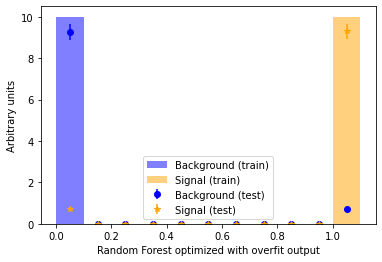

In [20]:
new_compare_train_test(best_random_fit, X_train_val, Y_train_val, X_test, Y_test, 'Random Forest optimized with overfit output')    

In [93]:
df_all[(df_all['isSignal'] == 1) & (df_all['dense_RF_opt']==0)].head()
print("Total number of Signals:", len(df_all[(df_all['isSignal'] == 1)]))
print("TNR:", len(df_all[(df_all['isSignal'] == 1) & (df_all['dense_RF_opt']==0)]))
print("Total number of Backgrounds:", len(df_all[(df_all['isSignal'] == 0)]))
print("FPR:", len(df_all[(df_all['isSignal'] == 0) & (df_all['dense_RF_opt']==1)]))

Total number of Signals: 94643
TNR: 29559
Total number of Backgrounds: 3265
FPR: 45
